# Sentiment Analysis and Twitter Post Popularity: A Data-Driven Investigation of the Correlation

Our main goal of this research is to investigate the corrleation between sentiments of the tweets with its popularity.

For this project we have used two different datasets. One is labeled (0 and 1 for positive and negative sentiments respectively) dataset and the other one is unlabeled dataset. It is not possible to find a single dataset with labels and the features we needed for our investogation therefore we decided to take this approach. 

Main features we needed in a single dataframe to conduct this research were: tweet text, number of likes for that tweet, number of shares for that tweet and the sentiment score for that tweet so that we could compute the correlation. As we could not conduct the research using single dataset we followed the process mentioned below:

1. After performing all the required preprocessing of the data, we first trained a classifcation model on the labeled dataset.

2. Then we used that trained classification model to predict the labels for our unlabeled dataset along with sentiment score which in this case was computed using predict_proba function of the classifier model.

3. Then we computed the popularity score using the features: number of likes and number of shares.

4. Then computed linear and non-linear correlation between the populariy and the sentiment score. 

The steps are explained along with the code in more details.

### Importing necessary libraries

In [36]:
#importing the libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [3]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rawbe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rawbe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rawbe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Reading the data

This is the first dataset which is labeled (0 for negative sentiment tweets and 1 for positive sentiment tweets). We will use this dataset to train a classification model so that we can use it for predicting labels and sentiment score for our main dataset which is unlabeled. 

In [4]:
#reading the data
data = pd.read_csv('trainingdata.csv', encoding='ISO-8859-1', header=None)
# naming the columns
data = data.rename(columns={0: 'label', 1: 'tweet_id', 2: 'date', 3: 'query', 4: 'user', 5: 'tweet_text'})
# replacing 4 with 1 for the positive tweets
data['label'] = data['label'].replace(4, 1)

In [5]:
data

,label,tweet_id,date,query,user,tweet_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
# dropping query column as we dont need it
data = data.drop('query', axis=1)
data

,label,tweet_id,date,user,tweet_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
# reindexing the columns
data = data[['tweet_id', 'user', 'date', 'tweet_text', 'label']]
data

,tweet_id,user,date,tweet_text,label
0,1467810369,_TheSpecialOne_,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,1467810672,scotthamilton,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,0
2,1467810917,mattycus,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,0
3,1467811184,ElleCTF,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,0
4,1467811193,Karoli,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",0
...,...,...,...,...,...
1599995,2193601966,AmandaMarie1028,Tue Jun 16 08:40:49 PDT 2009,Just woke up. Having no school is the best fee...,1
1599996,2193601969,TheWDBoards,Tue Jun 16 08:40:49 PDT 2009,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,2193601991,bpbabe,Tue Jun 16 08:40:49 PDT 2009,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,2193602064,tinydiamondz,Tue Jun 16 08:40:49 PDT 2009,Happy 38th Birthday to my boo of alll time!!! ...,1


In [8]:
# checking the class ratio in the data

num_pos = (data["label"] == 1).sum()
num_neg = (data["label"] == 0).sum()

print("Number of positive tweets:", num_pos)
print("Number of negative tweets:", num_neg)

Number of positive tweets: 800000
Number of negative tweets: 800000


In [9]:
data_01 = data.copy()

In [10]:
# removing @mentions from the tweet text
# we are doing this by applying a lambda function on the column 'tweet_text'
# the lambda function substitutes the '@...' with nothing
data_01['tweet_text'] = data_01['tweet_text'].apply(lambda x: re.sub('@[^\s]+','',x))

In [11]:
# removing links(urls) from the tweet text
# we are doing this by applying a lambda function to the column 'tweet_text'.
# the lambda function substitutes the 'https...' with nothing
data_01["tweet_text"] = data_01["tweet_text"].apply(lambda x: re.sub(r"http\S+", "", x))

In [12]:
# removing #hashtags from the tweet text
# we are doing this by applying a lambda function to the column 'tweet_text'.
# the lambda function substitutes the '#...' with nothing
data_01["tweet_text"] = data_01["tweet_text"].apply(lambda x: re.sub(r"#\S+", "", x))

In [13]:
#copying the data_01
data_02 = data_01.copy()
data_02

,tweet_id,user,date,tweet_text,label
0,1467810369,_TheSpecialOne_,Mon Apr 06 22:19:45 PDT 2009,"- Awww, that's a bummer. You shoulda got Da...",0
1,1467810672,scotthamilton,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,0
2,1467810917,mattycus,Mon Apr 06 22:19:53 PDT 2009,I dived many times for the ball. Managed to s...,0
3,1467811184,ElleCTF,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,0
4,1467811193,Karoli,Mon Apr 06 22:19:57 PDT 2009,"no, it's not behaving at all. i'm mad. why am...",0
...,...,...,...,...,...
1599995,2193601966,AmandaMarie1028,Tue Jun 16 08:40:49 PDT 2009,Just woke up. Having no school is the best fee...,1
1599996,2193601969,TheWDBoards,Tue Jun 16 08:40:49 PDT 2009,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,2193601991,bpbabe,Tue Jun 16 08:40:49 PDT 2009,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,2193602064,tinydiamondz,Tue Jun 16 08:40:49 PDT 2009,Happy 38th Birthday to my boo of alll time!!! ...,1


In [14]:
# lowercase the tweet text 
# here we are using a lambda function to lowercase the column 'tweet_text'
# and storing it in new column called 'tweet_text_cleaned' .
data_02['tweet_text_cleaned'] = data_02['tweet_text'].apply(lambda x: x.lower())

In [15]:
# function to remove all the emojis in the text
# we are defining a function that removes (substitutes with nothing) all the emojis that are stored in the list
# inside the function when it is applied to a text.
# afterwards, we are applying this function to the column 'tweet_text_cleaned'
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data_02['tweet_text_cleaned'] = data_02['tweet_text_cleaned'].apply(remove_emojis)


In [16]:
# remove all the punctuations from the text
data_02['tweet_text_cleaned'] = data_02['tweet_text_cleaned'].str.translate(str.maketrans('', '', string.punctuation))

In [17]:
# tokenize each string in the text using word_tokenize() function from NLTK library
data_02['tweet_text_cleaned'] = data_02['tweet_text_cleaned'].apply(lambda x: word_tokenize(x))

In [18]:
# removing stop words from the text using stopwords module from NLTK library
# we are first storing in a set all the stopwrods from language 'english'
# afterwards, we are applying a lambda function to remove all the stopwords stored in the set
# from the column 'tweet_text_cleaned'
stop_words = set(stopwords.words('english'))
data_02['tweet_text_cleaned'] = data_02['tweet_text_cleaned'].apply(lambda x: [token for token in x if token not in stop_words])


In [19]:
# lemmatize the words in the text using WordNetLeammatizer from NLTK library
# here we are also using a lambda function to apply WordNetLemmatizer to the words
lemmatizer = WordNetLemmatizer()
data_02['tweet_text_cleaned'] = data_02['tweet_text_cleaned'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])


In [20]:
# joining the tokens in each tweet into a single string
# we are using lambda function for this operation as well
data_02['tweet_text_cleaned'] = data_02['tweet_text_cleaned'].apply(lambda x: ' '.join(x))

In [21]:
# printing the dataframe 'data_02'
data_02

,tweet_id,user,date,tweet_text,label,tweet_text_cleaned
0,1467810369,_TheSpecialOne_,Mon Apr 06 22:19:45 PDT 2009,"- Awww, that's a bummer. You shoulda got Da...",0,awww thats bummer shoulda got david carr third...
1,1467810672,scotthamilton,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...
2,1467810917,mattycus,Mon Apr 06 22:19:53 PDT 2009,I dived many times for the ball. Managed to s...,0,dived many time ball managed save 50 rest go b...
3,1467811184,ElleCTF,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire
4,1467811193,Karoli,Mon Apr 06 22:19:57 PDT 2009,"no, it's not behaving at all. i'm mad. why am...",0,behaving im mad cant see
...,...,...,...,...,...,...
1599995,2193601966,AmandaMarie1028,Tue Jun 16 08:40:49 PDT 2009,Just woke up. Having no school is the best fee...,1,woke school best feeling ever
1599996,2193601969,TheWDBoards,Tue Jun 16 08:40:49 PDT 2009,TheWDB.com - Very cool to hear old Walt interv...,1,thewdbcom cool hear old walt interview â «
1599997,2193601991,bpbabe,Tue Jun 16 08:40:49 PDT 2009,Are you ready for your MoJo Makeover? Ask me f...,1,ready mojo makeover ask detail
1599998,2193602064,tinydiamondz,Tue Jun 16 08:40:49 PDT 2009,Happy 38th Birthday to my boo of alll time!!! ...,1,happy 38th birthday boo alll time tupac amaru ...


### Visualization of data

#### Horizontal Bar Plot for 20 most frequent words

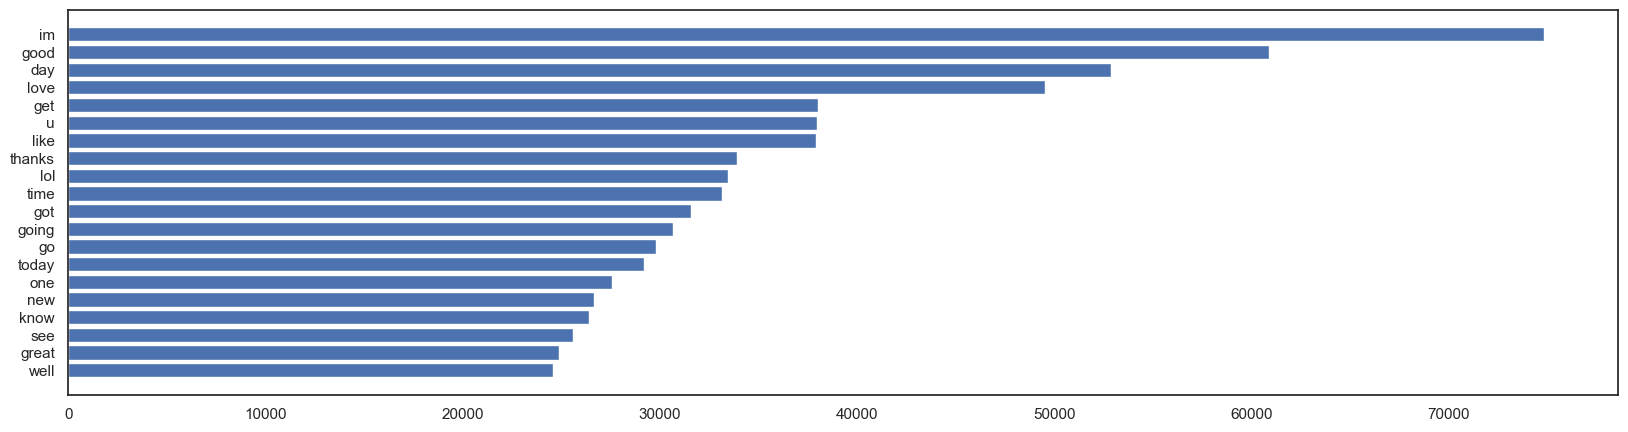

In [22]:
# With the following code we are plotting 20 most frequent positive words from the column 'tweet_text_cleaned'

# For Positive(1) Label

sns.set(style = 'white')
# Subset positive review dataset
all_words_df = data_02[data_02['label'] == 1]

# Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df ['tweet_text_cleaned']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})

# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 20) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

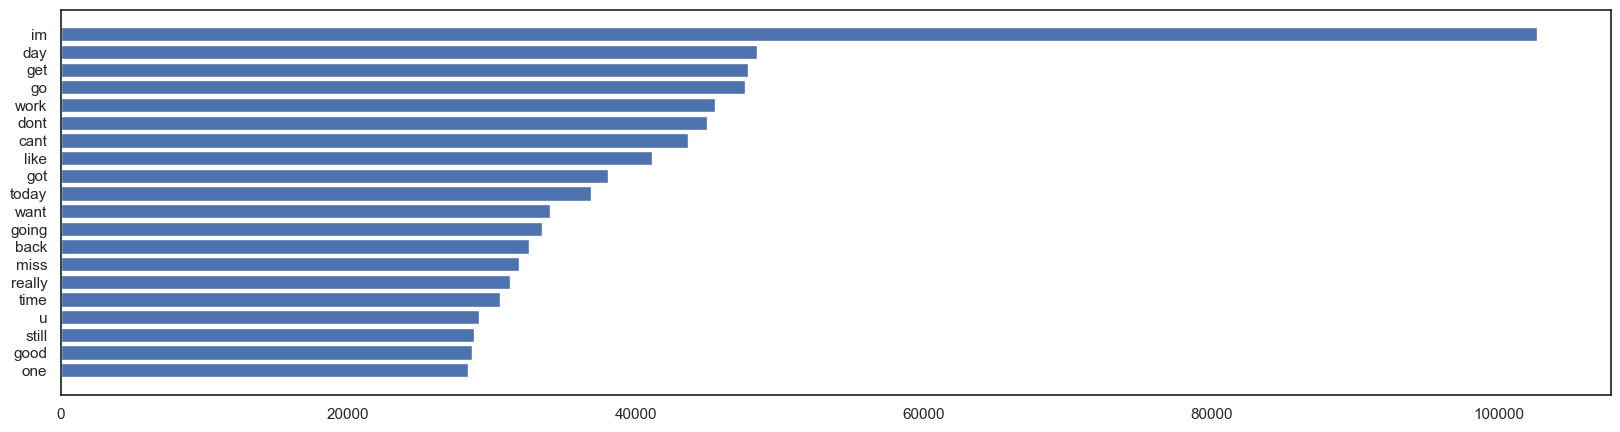

In [23]:
# With the following code we are plotting 20 most frequent negative words from the column 'tweet_text_cleaned'

# For Negative(0) Label

sns.set(style = 'white')
# Subset positive review dataset
all_words_df = data_02[data_02['label'] == 0]

# Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df ['tweet_text_cleaned']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})

# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 20) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

In [24]:
# Removing 'im' from all the texts as it had the most frequency for both labels
data_02['tweet_text_cleaned'] = data_02['tweet_text_cleaned'].str.replace('im', '')
data_02['tweet_text_cleaned'] = data_02['tweet_text_cleaned'].str.strip()
data_02

,tweet_id,user,date,tweet_text,label,tweet_text_cleaned
0,1467810369,_TheSpecialOne_,Mon Apr 06 22:19:45 PDT 2009,"- Awww, that's a bummer. You shoulda got Da...",0,awww thats bummer shoulda got david carr third...
1,1467810672,scotthamilton,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...
2,1467810917,mattycus,Mon Apr 06 22:19:53 PDT 2009,I dived many times for the ball. Managed to s...,0,dived many te ball managed save 50 rest go bound
3,1467811184,ElleCTF,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire
4,1467811193,Karoli,Mon Apr 06 22:19:57 PDT 2009,"no, it's not behaving at all. i'm mad. why am...",0,behaving mad cant see
...,...,...,...,...,...,...
1599995,2193601966,AmandaMarie1028,Tue Jun 16 08:40:49 PDT 2009,Just woke up. Having no school is the best fee...,1,woke school best feeling ever
1599996,2193601969,TheWDBoards,Tue Jun 16 08:40:49 PDT 2009,TheWDB.com - Very cool to hear old Walt interv...,1,thewdbcom cool hear old walt interview â «
1599997,2193601991,bpbabe,Tue Jun 16 08:40:49 PDT 2009,Are you ready for your MoJo Makeover? Ask me f...,1,ready mojo makeover ask detail
1599998,2193602064,tinydiamondz,Tue Jun 16 08:40:49 PDT 2009,Happy 38th Birthday to my boo of alll time!!! ...,1,happy 38th birthday boo alll te tupac amaru sh...


#### World Cloud Visualization 

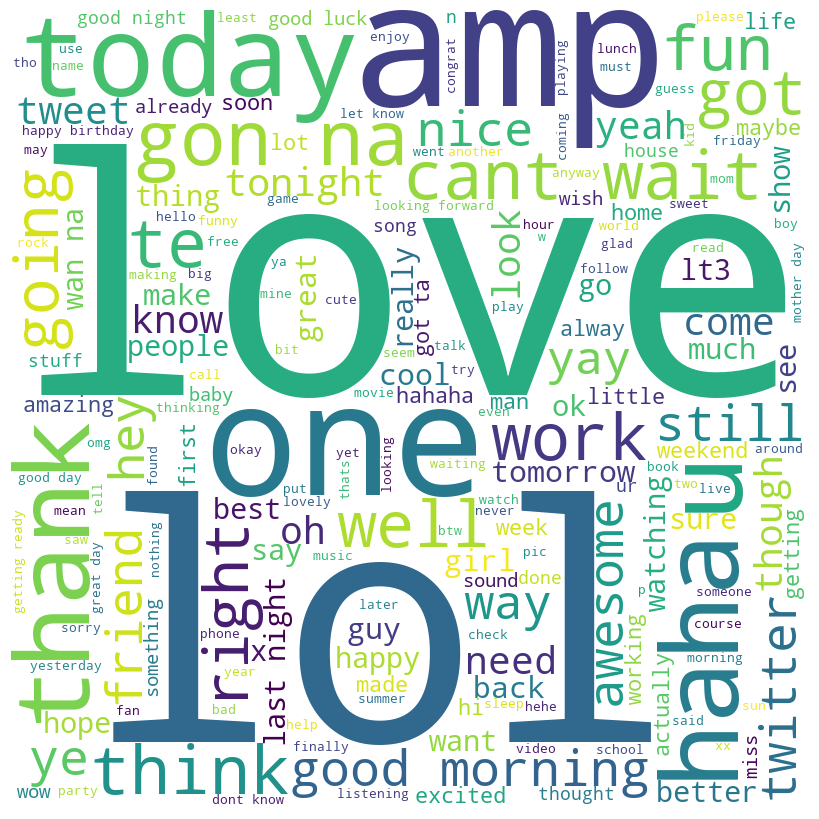

In [25]:
# Building a Word Cloud for positive (1) label
# getting the positive values

word_cloud_df_pos = data_02[data_02['label'] == 1]

# joining the positive words and storing them in the variable all_words_pos
all_words_pos = ' '.join([text for text in word_cloud_df_pos['tweet_text_cleaned']])
# building a word cloud with the positive words
wordcloud_pos = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words_pos)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

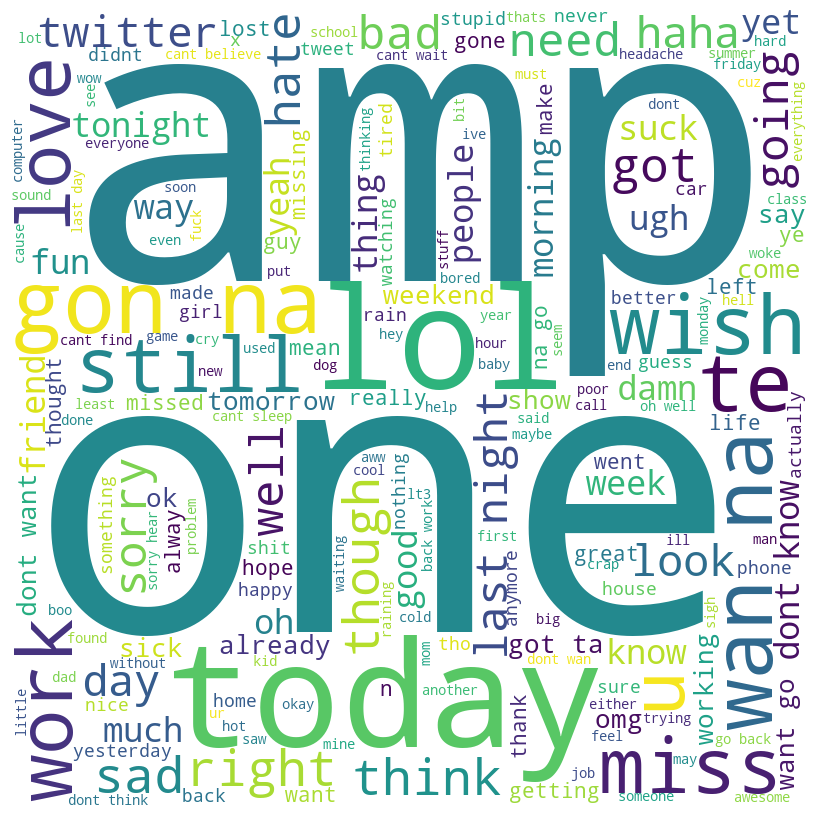

In [26]:
# Bilding a Word Cloud for negative (0) label
# getting the negative values

word_cloud_df_neg = data_02[data_02['label'] == 0]

# joining the negative words and storing them in the variable all_words_neg
all_words_neg = ' '.join([text for text in word_cloud_df_neg['tweet_text_cleaned']])
# building a word cloud with the negative words
wordcloud_neg = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words_neg)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [27]:
#storing the copy of data_02 in data_final 
data_final = data_02.copy()
data_final

,tweet_id,user,date,tweet_text,label,tweet_text_cleaned
0,1467810369,_TheSpecialOne_,Mon Apr 06 22:19:45 PDT 2009,"- Awww, that's a bummer. You shoulda got Da...",0,awww thats bummer shoulda got david carr third...
1,1467810672,scotthamilton,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...
2,1467810917,mattycus,Mon Apr 06 22:19:53 PDT 2009,I dived many times for the ball. Managed to s...,0,dived many te ball managed save 50 rest go bound
3,1467811184,ElleCTF,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire
4,1467811193,Karoli,Mon Apr 06 22:19:57 PDT 2009,"no, it's not behaving at all. i'm mad. why am...",0,behaving mad cant see
...,...,...,...,...,...,...
1599995,2193601966,AmandaMarie1028,Tue Jun 16 08:40:49 PDT 2009,Just woke up. Having no school is the best fee...,1,woke school best feeling ever
1599996,2193601969,TheWDBoards,Tue Jun 16 08:40:49 PDT 2009,TheWDB.com - Very cool to hear old Walt interv...,1,thewdbcom cool hear old walt interview â «
1599997,2193601991,bpbabe,Tue Jun 16 08:40:49 PDT 2009,Are you ready for your MoJo Makeover? Ask me f...,1,ready mojo makeover ask detail
1599998,2193602064,tinydiamondz,Tue Jun 16 08:40:49 PDT 2009,Happy 38th Birthday to my boo of alll time!!! ...,1,happy 38th birthday boo alll te tupac amaru sh...


In [28]:
# just choosing the feature that will be used to train the model and dropping the rest of the columns
data_final = data_final.drop(['tweet_id', 'user', 'date', 'tweet_text'], axis=1)
data_final

,label,tweet_text_cleaned
0,0,awww thats bummer shoulda got david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,dived many te ball managed save 50 rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad cant see
...,...,...
1599995,1,woke school best feeling ever
1599996,1,thewdbcom cool hear old walt interview â «
1599997,1,ready mojo makeover ask detail
1599998,1,happy 38th birthday boo alll te tupac amaru sh...


In [29]:
# creating a regular expression tokenizer 
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
# creating a count vectorizer object with English stop words and unigram tokens
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
# fitting the count vectorizer to the tweet text and transforming the text into matrix of token counts
text_counts = cv.fit_transform(data_final['tweet_text_cleaned'])

C:\Users\rawbe\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [30]:
#Splitting the data into trainig and testing
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, data_final['label'], test_size=0.25, random_state=5, stratify=data_final['label'])

In [32]:
# hyperparameter tunning with GridSearchCV for Multinomial Naive Bayes classifier
# this is done by at first storing possible alpha values in 'parameters', afterwards applying GridSearchCV for
# MNB to the parameters and fitting it to X_train and y_train.
parameters = {'alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}
MNB = MultinomialNB()
clf = GridSearchCV(MNB, parameters)
clf.fit(X_train, Y_train)

# Printing the best parameters and the best score
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 3.5}
0.7646633333333334


In [33]:
#Training the model with the best parameter
MNB = MultinomialNB(alpha=3.5)
MNB.fit(X_train, Y_train)

MultinomialNB(alpha=3.5)

In [34]:
# predicting on the testing dataset and printing the accuracy score
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ",accuracy_score)

Accuracy Score:  0.7651875


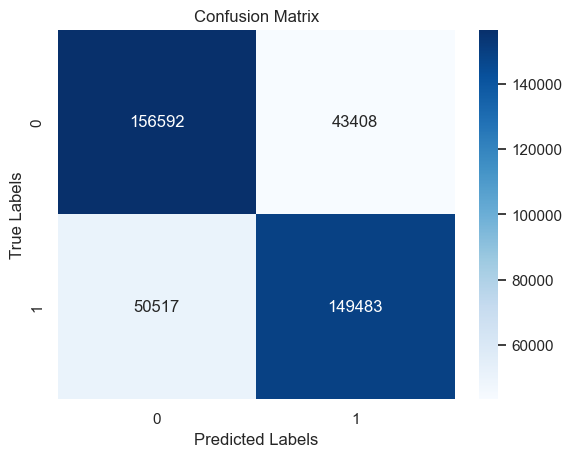

Precision:  0.7749609883301969
Recall:  0.747415
F1 score:  0.7609387845483863


In [37]:
# Displaying confusion matrix and computing precision, recall, and F1 score
cm = confusion_matrix(Y_test, predicted)

precision = precision_score(Y_test, predicted)
recall = recall_score(Y_test, predicted)
f1 = f1_score(Y_test, predicted)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1)

## Main Dataset

This is our main dataset which doesnot have labels but does have number of likes and number of shares features. Now as we already have trained a classification model. We will be using it to predict the label and the sentiment score for each tweet in this dataset.

In [38]:
# Reading the data
df = pd.read_csv('clean_tweets_final.csv')
df

,author,content,date_time,id,language,number_of_likes,number_of_shares,hashtags,mentions,link,content_without_stopwords
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,12/01/2017 19:52,8.196330e+17,en,7900,3472,#DONTNORMALIZEHATE,missing,https://t.co/ngG11quhmK,is history repeating itself...?
1,katyperry,@barackobama Thank you for your incredible gra...,11/01/2017 08:38,8.191010e+17,en,3689,1380,missing,@barackobama,https://t.co/ZuQLZpt6df,thank incredible grace leadership exceptional…
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,11/01/2017 02:52,8.190140e+17,en,10341,2387,missing,missing,https://t.co/XIn1qKMKQl,life goals.
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,11/01/2017 02:44,8.190120e+17,en,10774,2458,missing,missing,https://t.co/gW55C1wrwd,me right folded_hands_light_skin_tone
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,10/01/2017 05:22,8.186890e+17,en,17620,4655,missing,missing,https://t.co/0shuUYUBEv,sisters are doin' it for themselves! raising_h...
...,...,...,...,...,...,...,...,...,...,...,...
41370,ddlovato,Ummm just cried. Congratulations to @HereIsGin...,12/01/2015 01:43,5.544540e+17,en,20252,11533,missing,@HereIsGina,missing,ummm cried. congratulations golden globe... wa...
41371,ddlovato,"Well, I didn't end up getting any brownie batt...",11/01/2015 06:35,5.541650e+17,en,21711,11910,#20FITteen,missing,missing,"well, i end getting brownie batter i yummy sus..."
41372,ddlovato,@yelyahwilliams the stuff is reallllllyyyy cut...,10/01/2015 02:29,5.537400e+17,en,10715,7261,missing,@yelyahwilliams,missing,stuff reallllllyyyy cute comfy too!! i'll send...
41373,ddlovato,I’m going to #color2015 with health and love 💪...,10/01/2015 01:19,5.537230e+17,en,17092,10401,#color2015,@mysecretcolor,missing,i’m going health love flexed_bicepsred_heart h...


In [39]:
# checking for null values
print(df.isnull().sum())

author                        0
content                       0
date_time                     0
id                            0
language                      0
number_of_likes               0
number_of_shares              0
hashtags                      0
mentions                      0
link                          0
content_without_stopwords    24
dtype: int64


In [40]:
# removing null values
df.dropna(inplace=True)
df

,author,content,date_time,id,language,number_of_likes,number_of_shares,hashtags,mentions,link,content_without_stopwords
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,12/01/2017 19:52,8.196330e+17,en,7900,3472,#DONTNORMALIZEHATE,missing,https://t.co/ngG11quhmK,is history repeating itself...?
1,katyperry,@barackobama Thank you for your incredible gra...,11/01/2017 08:38,8.191010e+17,en,3689,1380,missing,@barackobama,https://t.co/ZuQLZpt6df,thank incredible grace leadership exceptional…
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,11/01/2017 02:52,8.190140e+17,en,10341,2387,missing,missing,https://t.co/XIn1qKMKQl,life goals.
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,11/01/2017 02:44,8.190120e+17,en,10774,2458,missing,missing,https://t.co/gW55C1wrwd,me right folded_hands_light_skin_tone
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,10/01/2017 05:22,8.186890e+17,en,17620,4655,missing,missing,https://t.co/0shuUYUBEv,sisters are doin' it for themselves! raising_h...
...,...,...,...,...,...,...,...,...,...,...,...
41370,ddlovato,Ummm just cried. Congratulations to @HereIsGin...,12/01/2015 01:43,5.544540e+17,en,20252,11533,missing,@HereIsGina,missing,ummm cried. congratulations golden globe... wa...
41371,ddlovato,"Well, I didn't end up getting any brownie batt...",11/01/2015 06:35,5.541650e+17,en,21711,11910,#20FITteen,missing,missing,"well, i end getting brownie batter i yummy sus..."
41372,ddlovato,@yelyahwilliams the stuff is reallllllyyyy cut...,10/01/2015 02:29,5.537400e+17,en,10715,7261,missing,@yelyahwilliams,missing,stuff reallllllyyyy cute comfy too!! i'll send...
41373,ddlovato,I’m going to #color2015 with health and love 💪...,10/01/2015 01:19,5.537230e+17,en,17092,10401,#color2015,@mysecretcolor,missing,i’m going health love flexed_bicepsred_heart h...


##### Applying the same approaches for preprocessing as for the training dataset

In [41]:
# function to remove punctuation marks
# here we define 'pattern' that stores all the punctuations
# afterwards, we define 'text_without_punct' that stores all the text without punctuations. this is done by 
# substituting the punctuations stored in side 'pattern' with nothing (''). Afterwards, inside the same column
# we replace _ with space (' ') and return the 'text_without_punct' 
# finally, we apply this function to the 'content_without_stopwords' column
def remove_punctuation(text):
    pattern = r'[^\w\s_]'
    text_without_punct = re.sub(pattern, '', text)
    # Replace underscores with spaces
    text_without_punct = text_without_punct.replace('_', ' ')
    return text_without_punct

df['content_without_stopwords'] = df['content_without_stopwords'].apply(remove_punctuation)


In [42]:
# Removing 'im' from all the texts as it had the most frequency for both labels in this dataset as well
df['content_without_stopwords'] = df['content_without_stopwords'].str.replace('im', '')
df['content_without_stopwords'] = df['content_without_stopwords'].str.strip()
df

,author,content,date_time,id,language,number_of_likes,number_of_shares,hashtags,mentions,link,content_without_stopwords
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,12/01/2017 19:52,8.196330e+17,en,7900,3472,#DONTNORMALIZEHATE,missing,https://t.co/ngG11quhmK,is history repeating itself
1,katyperry,@barackobama Thank you for your incredible gra...,11/01/2017 08:38,8.191010e+17,en,3689,1380,missing,@barackobama,https://t.co/ZuQLZpt6df,thank incredible grace leadership exceptional
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,11/01/2017 02:52,8.190140e+17,en,10341,2387,missing,missing,https://t.co/XIn1qKMKQl,life goals
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,11/01/2017 02:44,8.190120e+17,en,10774,2458,missing,missing,https://t.co/gW55C1wrwd,me right folded hands light skin tone
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,10/01/2017 05:22,8.186890e+17,en,17620,4655,missing,missing,https://t.co/0shuUYUBEv,sisters are doin it for themselves raising han...
...,...,...,...,...,...,...,...,...,...,...,...
41370,ddlovato,Ummm just cried. Congratulations to @HereIsGin...,12/01/2015 01:43,5.544540e+17,en,20252,11533,missing,@HereIsGina,missing,ummm cried congratulations golden globe way re...
41371,ddlovato,"Well, I didn't end up getting any brownie batt...",11/01/2015 06:35,5.541650e+17,en,21711,11910,#20FITteen,missing,missing,well i end getting brownie batter i yummy sush...
41372,ddlovato,@yelyahwilliams the stuff is reallllllyyyy cut...,10/01/2015 02:29,5.537400e+17,en,10715,7261,missing,@yelyahwilliams,missing,stuff reallllllyyyy cute comfy too ill send th...
41373,ddlovato,I’m going to #color2015 with health and love 💪...,10/01/2015 01:19,5.537230e+17,en,17092,10401,#color2015,@mysecretcolor,missing,going health love flexed bicepsred heart how y...


In [43]:
# tokenize each string in the text using word_tokenize() function from NLTK library
# this is done using a lambda function
df['content_without_stopwords'] = df['content_without_stopwords'].apply(lambda x: word_tokenize(x))

In [44]:
# removing stop words from the text using stopwords module from NLTK library
# we are storing the stopwords from english language inside 'stop_words'
# afterwards, we are using a lambda function to remove these stopwords from the text
stop_words = set(stopwords.words('english'))
df['content_without_stopwords'] = df['content_without_stopwords'].apply(lambda x: [token for token in x if token not in stop_words])

In [45]:
# lemmatize the words in the text using WordNetLeammatizer from NLTK library
# this is done by applying WordNetLemmnatizer() on the column 'content_without_stopwords' with a lambda function
lemmatizer = WordNetLemmatizer()
df['content_without_stopwords'] = df['content_without_stopwords'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

In [46]:
# joining the tokens in each tweet into a single string
# this is also done using a lambda function
df['content_without_stopwords'] = df['content_without_stopwords'].apply(lambda x: ' '.join(x))

In [47]:
# printing df
df

,author,content,date_time,id,language,number_of_likes,number_of_shares,hashtags,mentions,link,content_without_stopwords
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,12/01/2017 19:52,8.196330e+17,en,7900,3472,#DONTNORMALIZEHATE,missing,https://t.co/ngG11quhmK,history repeating
1,katyperry,@barackobama Thank you for your incredible gra...,11/01/2017 08:38,8.191010e+17,en,3689,1380,missing,@barackobama,https://t.co/ZuQLZpt6df,thank incredible grace leadership exceptional
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,11/01/2017 02:52,8.190140e+17,en,10341,2387,missing,missing,https://t.co/XIn1qKMKQl,life goal
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,11/01/2017 02:44,8.190120e+17,en,10774,2458,missing,missing,https://t.co/gW55C1wrwd,right folded hand light skin tone
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,10/01/2017 05:22,8.186890e+17,en,17620,4655,missing,missing,https://t.co/0shuUYUBEv,sister doin raising hand light skin toneflexed...
...,...,...,...,...,...,...,...,...,...,...,...
41370,ddlovato,Ummm just cried. Congratulations to @HereIsGin...,12/01/2015 01:43,5.544540e+17,en,20252,11533,missing,@HereIsGina,missing,ummm cried congratulation golden globe way rep...
41371,ddlovato,"Well, I didn't end up getting any brownie batt...",11/01/2015 06:35,5.541650e+17,en,21711,11910,#20FITteen,missing,missing,well end getting brownie batter yummy sushi sushi
41372,ddlovato,@yelyahwilliams the stuff is reallllllyyyy cut...,10/01/2015 02:29,5.537400e+17,en,10715,7261,missing,@yelyahwilliams,missing,stuff reallllllyyyy cute comfy ill send thumb ...
41373,ddlovato,I’m going to #color2015 with health and love 💪...,10/01/2015 01:19,5.537230e+17,en,17092,10401,#color2015,@mysecretcolor,missing,going health love flexed bicepsred heart cc


In [48]:
#making the copy of df as df_pretrained
df_pretrained = df.copy()

In [49]:
# extracting the feature column from the dataframe
feature_df = df['content_without_stopwords']
# preprocessing the feature data using the same CountVectorizer that we used during training
feature_counts = cv.transform(feature_df)
# getting the predicted probabilities for each class
label_probabilities = MNB.predict_proba(feature_counts)
sentiment_scores = label_probabilities[:, 1]
# adding sentiment_score column in the dataframe (1 being extremely positive and 0 being extremely negative)
df['sentiment_score'] = sentiment_scores
# adding a label column to the dataframe (0 or 1)
predicted_labels = MNB.predict(feature_counts)
df['label'] = predicted_labels

In [50]:
#printing df
df

,author,content,date_time,id,language,number_of_likes,number_of_shares,hashtags,mentions,link,content_without_stopwords,sentiment_score,label
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,12/01/2017 19:52,8.196330e+17,en,7900,3472,#DONTNORMALIZEHATE,missing,https://t.co/ngG11quhmK,history repeating,0.458817,0
1,katyperry,@barackobama Thank you for your incredible gra...,11/01/2017 08:38,8.191010e+17,en,3689,1380,missing,@barackobama,https://t.co/ZuQLZpt6df,thank incredible grace leadership exceptional,0.996577,1
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,11/01/2017 02:52,8.190140e+17,en,10341,2387,missing,missing,https://t.co/XIn1qKMKQl,life goal,0.652624,1
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,11/01/2017 02:44,8.190120e+17,en,10774,2458,missing,missing,https://t.co/gW55C1wrwd,right folded hand light skin tone,0.434695,0
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,10/01/2017 05:22,8.186890e+17,en,17620,4655,missing,missing,https://t.co/0shuUYUBEv,sister doin raising hand light skin toneflexed...,0.370658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41370,ddlovato,Ummm just cried. Congratulations to @HereIsGin...,12/01/2015 01:43,5.544540e+17,en,20252,11533,missing,@HereIsGina,missing,ummm cried congratulation golden globe way rep...,0.986698,1
41371,ddlovato,"Well, I didn't end up getting any brownie batt...",11/01/2015 06:35,5.541650e+17,en,21711,11910,#20FITteen,missing,missing,well end getting brownie batter yummy sushi sushi,0.827091,1
41372,ddlovato,@yelyahwilliams the stuff is reallllllyyyy cut...,10/01/2015 02:29,5.537400e+17,en,10715,7261,missing,@yelyahwilliams,missing,stuff reallllllyyyy cute comfy ill send thumb ...,0.879047,1
41373,ddlovato,I’m going to #color2015 with health and love 💪...,10/01/2015 01:19,5.537230e+17,en,17092,10401,#color2015,@mysecretcolor,missing,going health love flexed bicepsred heart cc,0.662179,1


In [51]:
# storing the copy of df inside df_final
df_final = df.copy()

### Visualization of data

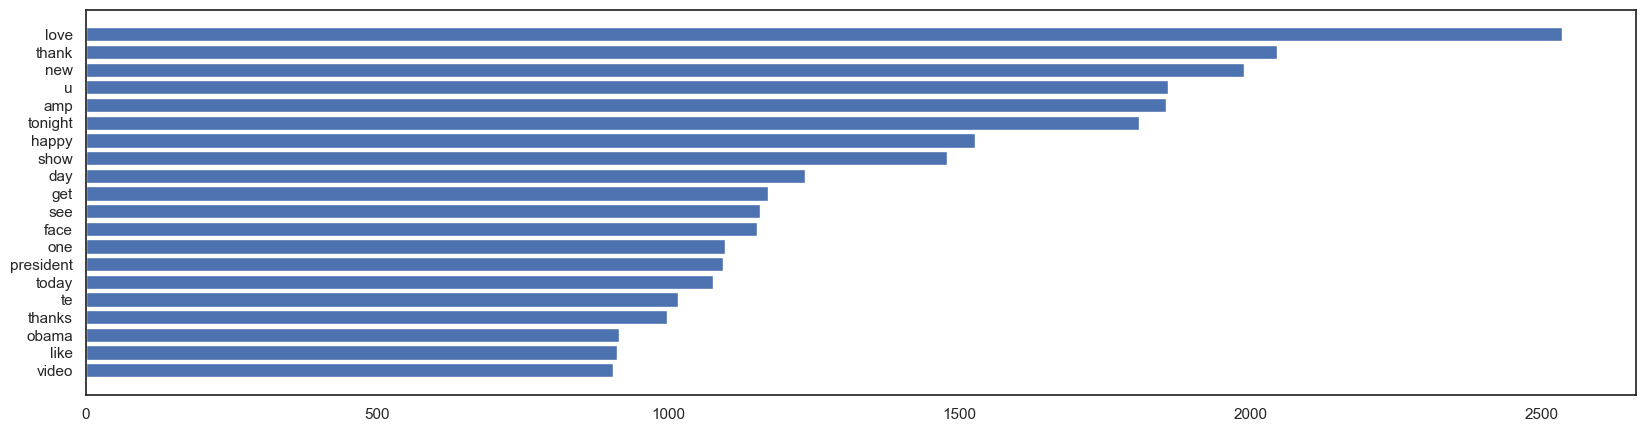

In [52]:
# plotting the most common positive 20 words

# For Positive(1) Label

sns.set(style = 'white')
# Subset positive review dataset
all_words_df = df_final[df_final['label'] == 1]

# Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df ['content_without_stopwords']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})

# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 20) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

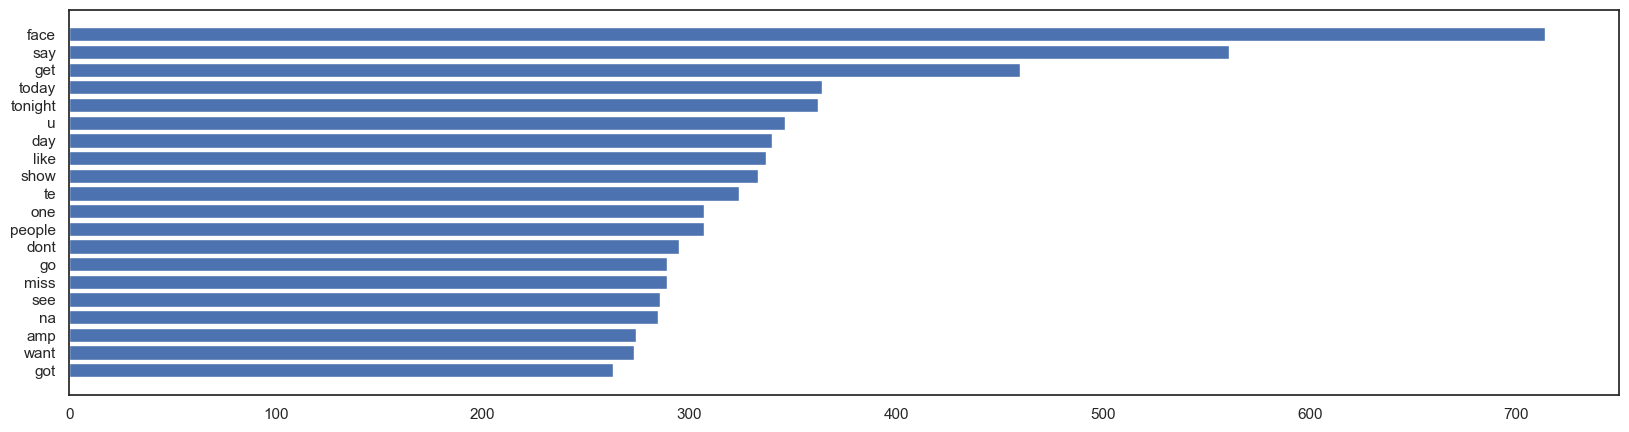

In [53]:
# plotting the most common 20 negative words

# For Negative(0) Label

sns.set(style = 'white')
# Subset positive review dataset
all_words_df = df_final[df_final['label'] == 0]

# Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df ['content_without_stopwords']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})

# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 20) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,5))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

#### World Cloud Visualization 

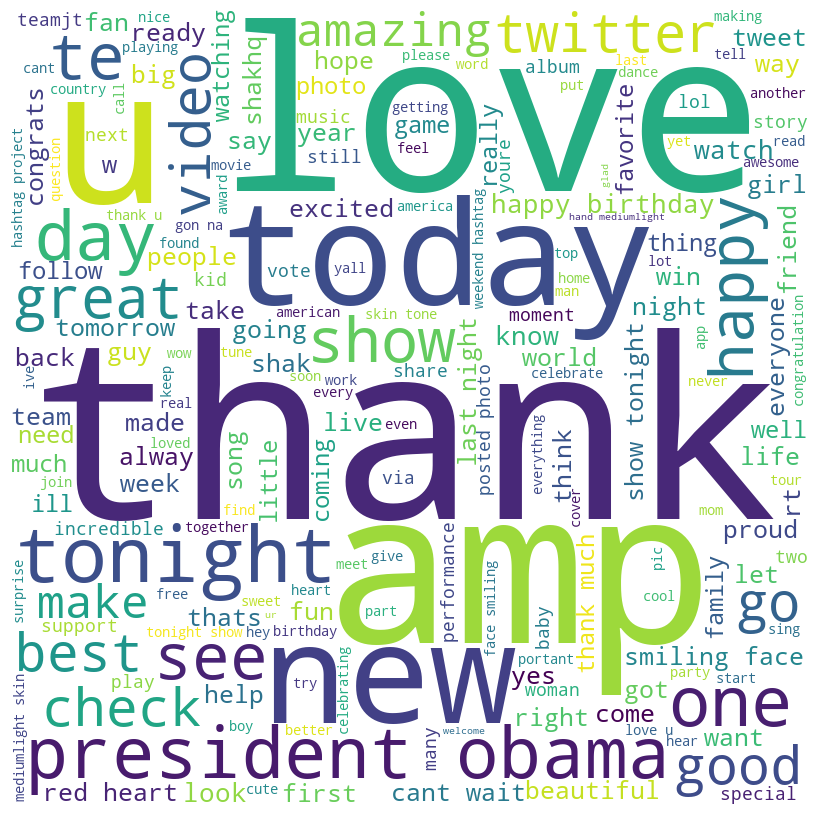

In [54]:
# Building a Word Cloud for positive (1) label
# identifying positive words

word_cloud_df_pos = df_final[df_final['label'] == 1]
# joining the identified positive words
all_words_pos = ' '.join([text for text in word_cloud_df_pos['content_without_stopwords']])
# building a word cloud with the positive words
wordcloud_pos = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words_pos)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

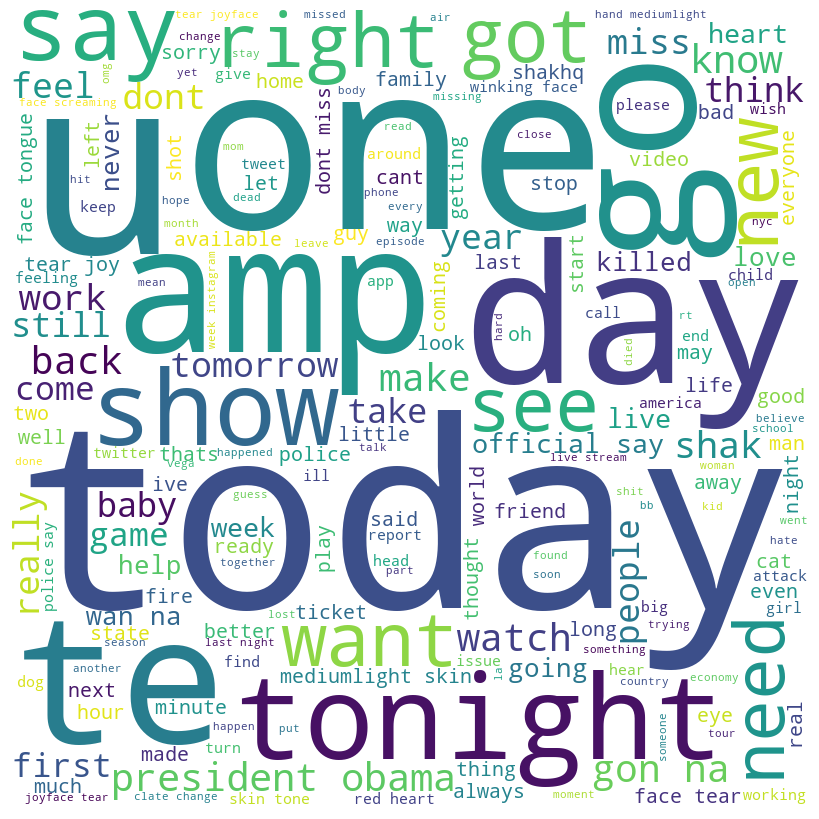

In [55]:
# Bilding a Word Cloud for negative (0) label
# identifying the negative words

word_cloud_df_neg = df_final[df_final['label'] == 0]
# joining the negative words
all_words_neg = ' '.join([text for text in word_cloud_df_neg['content_without_stopwords']])
# creating a word cloud with the negative words
wordcloud_neg = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words_neg)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [56]:
#storing the copy of df_final in df_conclusion
df_conclusion = df_final.copy()
df_conclusion

,author,content,date_time,id,language,number_of_likes,number_of_shares,hashtags,mentions,link,content_without_stopwords,sentiment_score,label
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,12/01/2017 19:52,8.196330e+17,en,7900,3472,#DONTNORMALIZEHATE,missing,https://t.co/ngG11quhmK,history repeating,0.458817,0
1,katyperry,@barackobama Thank you for your incredible gra...,11/01/2017 08:38,8.191010e+17,en,3689,1380,missing,@barackobama,https://t.co/ZuQLZpt6df,thank incredible grace leadership exceptional,0.996577,1
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,11/01/2017 02:52,8.190140e+17,en,10341,2387,missing,missing,https://t.co/XIn1qKMKQl,life goal,0.652624,1
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,11/01/2017 02:44,8.190120e+17,en,10774,2458,missing,missing,https://t.co/gW55C1wrwd,right folded hand light skin tone,0.434695,0
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,10/01/2017 05:22,8.186890e+17,en,17620,4655,missing,missing,https://t.co/0shuUYUBEv,sister doin raising hand light skin toneflexed...,0.370658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41370,ddlovato,Ummm just cried. Congratulations to @HereIsGin...,12/01/2015 01:43,5.544540e+17,en,20252,11533,missing,@HereIsGina,missing,ummm cried congratulation golden globe way rep...,0.986698,1
41371,ddlovato,"Well, I didn't end up getting any brownie batt...",11/01/2015 06:35,5.541650e+17,en,21711,11910,#20FITteen,missing,missing,well end getting brownie batter yummy sushi sushi,0.827091,1
41372,ddlovato,@yelyahwilliams the stuff is reallllllyyyy cut...,10/01/2015 02:29,5.537400e+17,en,10715,7261,missing,@yelyahwilliams,missing,stuff reallllllyyyy cute comfy ill send thumb ...,0.879047,1
41373,ddlovato,I’m going to #color2015 with health and love 💪...,10/01/2015 01:19,5.537230e+17,en,17092,10401,#color2015,@mysecretcolor,missing,going health love flexed bicepsred heart cc,0.662179,1


In [57]:
#creating a new column in df_conclusion called 'popularity' based on columns number_of_likes and
#number_of_shares
df_conclusion['popularity'] = df_conclusion['number_of_likes'] + 3 * df_conclusion['number_of_shares']
df_conclusion

,author,content,date_time,id,language,number_of_likes,number_of_shares,hashtags,mentions,link,content_without_stopwords,sentiment_score,label,popularity
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,12/01/2017 19:52,8.196330e+17,en,7900,3472,#DONTNORMALIZEHATE,missing,https://t.co/ngG11quhmK,history repeating,0.458817,0,18316
1,katyperry,@barackobama Thank you for your incredible gra...,11/01/2017 08:38,8.191010e+17,en,3689,1380,missing,@barackobama,https://t.co/ZuQLZpt6df,thank incredible grace leadership exceptional,0.996577,1,7829
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,11/01/2017 02:52,8.190140e+17,en,10341,2387,missing,missing,https://t.co/XIn1qKMKQl,life goal,0.652624,1,17502
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,11/01/2017 02:44,8.190120e+17,en,10774,2458,missing,missing,https://t.co/gW55C1wrwd,right folded hand light skin tone,0.434695,0,18148
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,10/01/2017 05:22,8.186890e+17,en,17620,4655,missing,missing,https://t.co/0shuUYUBEv,sister doin raising hand light skin toneflexed...,0.370658,0,31585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41370,ddlovato,Ummm just cried. Congratulations to @HereIsGin...,12/01/2015 01:43,5.544540e+17,en,20252,11533,missing,@HereIsGina,missing,ummm cried congratulation golden globe way rep...,0.986698,1,54851
41371,ddlovato,"Well, I didn't end up getting any brownie batt...",11/01/2015 06:35,5.541650e+17,en,21711,11910,#20FITteen,missing,missing,well end getting brownie batter yummy sushi sushi,0.827091,1,57441
41372,ddlovato,@yelyahwilliams the stuff is reallllllyyyy cut...,10/01/2015 02:29,5.537400e+17,en,10715,7261,missing,@yelyahwilliams,missing,stuff reallllllyyyy cute comfy ill send thumb ...,0.879047,1,32498
41373,ddlovato,I’m going to #color2015 with health and love 💪...,10/01/2015 01:19,5.537230e+17,en,17092,10401,#color2015,@mysecretcolor,missing,going health love flexed bicepsred heart cc,0.662179,1,48295


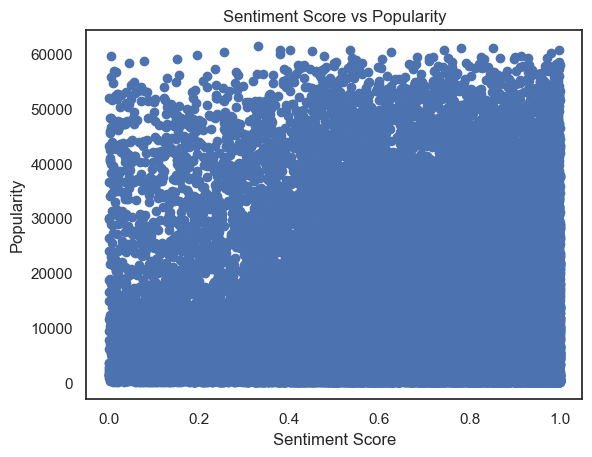

In [58]:
# Scatter plot of sentiment_score vs popularity
plt.scatter(df_conclusion['sentiment_score'], df_conclusion['popularity'])
plt.xlabel('Sentiment Score')
plt.ylabel('Popularity')
plt.title('Sentiment Score vs Popularity')
plt.show()

In [59]:
# Calculating the Pearson correlation coefficients to see linear relationship
pearson_correlation = df_conclusion['sentiment_score'].corr(df_conclusion['popularity'])

print(f"Pearson Rank Correlation Coefficient between sentiment score and popularity:", pearson_correlation)

Pearson Rank Correlation Coefficient between sentiment score and popularity: -0.01642018451198498


In [60]:
# Calculating the Spearmans correlation coefficients to see non-linear relationship
spearmans_correlation, p_value = spearmanr(df_conclusion['sentiment_score'], df_conclusion['popularity'])

print(f"Spearman's Rank Correlation Coefficient between sentiment score and popularity:", spearmans_correlation)

Spearman's Rank Correlation Coefficient between sentiment score and popularity: -0.014611630546218635


Looking at the values received for both Pearson and Spearman's correlation coefficient, we can conclude that there is neither linear nor non-linear correlation between popularity and sentiment score of tweets in the analyzed dataset.